# Train Contrastive Learning CNN-Model

This notebook will train our model based on pictures in our sorted_images folder and sub-folders.

In [ ]:
!pip install tensorflow_addons

In [5]:
#load the modules
import keras
import random
from keras import models, layers
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from tensorflow_addons.losses import ContrastiveLoss
from keras.activations import relu, softmax
from tensorflow.keras.applications import VGG19, ResNet50V2
from keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Dense, Flatten, concatenate
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.modules['Image'] = Image

/Users/tobiasengbring/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [6]:
image_dir = "../images/"
train_data = pd.read_csv('../data/train_corrected.csv')
train_data.image_id = train_data.image_id.apply(lambda x: x.strip()+".JPG")
train_data.image_location = train_data.image_location.apply(lambda x: x.lower())

from sklearn.utils import shuffle
train_data = shuffle(train_data, random_state=2)

#Load test data
test_data = pd.read_csv('../data/test_corrected.csv')
test_data.image_id = test_data.image_id.apply(lambda x: x.strip()+".JPG")
test_data.image_location = test_data.image_location.apply(lambda x: x.lower())

#Split data using image location
train_data_left = train_data.loc[train_data['image_location']=='left']
train_data_right = train_data.loc[train_data['image_location']=='right']
train_data_top = train_data.loc[train_data['image_location']=='top']

#Get unique_turtle_ids from train.csv
unique_turtle_ids = list(train_data['turtle_id'].unique())
#Add category for new turtle for test set
unique_turtle_ids.append("new_turtle")

#Get number of images for train/test split
split = 0.7
#lines = round(len(train_data))*split) #used if one model for all is trained
lines = round(min(len(train_data_left),len(train_data_right),len(train_data_top))*split) #used if three models for each location are trained
#length_data = max(len(train_data_left),len(train_data_right),len(train_data_top))

In [7]:
HEIGHT = 224 #image height
WIDTH = 224 #image width
CHANNELS = 3 #image RGB channels
CLASS_NAMES = unique_turtle_ids
NCLASSES = len(CLASS_NAMES)
BATCH_SIZE = 32
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

TRAINING_SIZE = lines
#VALIDATION_SIZE = length_data - lines                    
#VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE

In [8]:
image_dir = "../images/"

In [9]:
# Keras' data generator can be used to pass the images through the convolutional neural network and apply
#rotation and zoom transformations to the images. Check https://keras.io/preprocessing/image/ for more transformations

train_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        zoom_range=0.2,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #fill_mode='nearest'
)

train_generator_left = train_data.flow_from_dataframe(train_data_left[:lines],
        directory=image_dir,
        x_col       = "image_id",
        y_col       = "turtle_id",
        target_size=(224, 224),
        batch_size=510,
        class_mode  = 'sparse',
        shuffle=True)

train_generator_right = train_data.flow_from_dataframe(train_data_right[:lines],
        directory=image_dir,
        x_col       = "image_id",
        y_col       = "turtle_id",
        target_size=(224, 224),
        batch_size=510,
        class_mode  = 'sparse',
        shuffle=True)

train_generator_top = train_data.flow_from_dataframe(train_data_top[:lines],
        directory=image_dir,
        x_col       = "image_id",
        y_col       = "turtle_id",
        target_size=(224, 224),
        batch_size=510,
        class_mode  = 'sparse',
        shuffle=True)

Found 476 validated image filenames belonging to 100 classes.
Found 476 validated image filenames belonging to 99 classes.
Found 476 validated image filenames belonging to 100 classes.


In [10]:
#defining the validation data generator
val_data = ImageDataGenerator(rescale = 1./255)
                                 
val_generator_left = val_data.flow_from_dataframe(train_data_left[lines:],
        directory=image_dir,
        x_col       = "image_id",
        y_col       = "turtle_id",
        target_size=(224, 224),
        batch_size=170,
        class_mode  = 'sparse',
        shuffle=True)


val_generator_right = train_data.flow_from_dataframe(train_data_right[lines:],
        directory=image_dir,
        x_col       = "image_id",
        y_col       = "turtle_id",
        target_size=(224, 224),
        batch_size=178,
        class_mode  = 'sparse',
        shuffle=True)

val_generator_top = train_data.flow_from_dataframe(train_data_top[lines:],
        directory=image_dir,
        x_col       = "image_id",
        y_col       = "turtle_id",
        batch_size=244,
        class_mode  = 'sparse',
        shuffle=True)

Found 204 validated image filenames belonging to 83 classes.
Found 212 validated image filenames belonging to 84 classes.
Found 278 validated image filenames belonging to 89 classes.


In [11]:
test_datagenerator = ImageDataGenerator(rescale = 1./255)
test_datagen = test_datagenerator.flow_from_dataframe(
                dataframe = test_data, 
                directory   = image_dir,
                x_col       = "image_id",
                target_size = (HEIGHT, WIDTH),
                batch_size  = 1,
                class_mode  = None,
                shuffle     = False)

Found 490 validated image filenames.


## Model for left images

In [12]:
# Load the train and test data splits
x_train, y_train  = next(train_generator_left)
x_val, y_val  = next(val_generator_left)
#x_test = next(test_datagen)

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (476, 224, 224, 3) - y_train shape: (476,)
x_val shape: (170, 224, 224, 3) - y_val shape: (170,)


In [13]:
x_train = x_train.astype("float32")
x_val = x_val.astype("float32")

In [14]:
y_train.shape

(476,)

## Define model for contrastive learning

In [15]:
epochs = 30
batch_size = 64
margin = 1  # Margin for constrastive loss.

In [16]:
num_classes = max(y_train) + 1
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add matching examples
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


In [12]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    pairs = []
    labels = []
    pairs_indices = []
    
    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = int(y[idx1])
        
        for i in range(len(x)):
            idx2 = digit_indices[label1]
            if idx2 > idx1:
                x2 = x[idx2]
                label2 = int(y[idx2])
                pairs_indices += [[idx1, idx2]]
                pairs += [[x1, x2]]
            
                #Check, if it is a matching example (1) or not (0)
                if label1 == label2:
                    labels += [1]
                else:
                    labels += [0]
                                  
    return np.array(pairs), np.array(labels).astype("float32"), np.array(pairs_indices)

In [ ]:
# make train pairs
pairs_train, labels_train, pairs_indices_train = make_pairs(x_train, y_train)

In [ ]:
# make validation pairs
pairs_val, labels_val, pairs_indices_val = make_pairs(x_val, y_val)

In [1]:
pairs_indices_val

NameError: name 'pairs_indices_val' is not defined

In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [129]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

Metal device set to: Apple M1


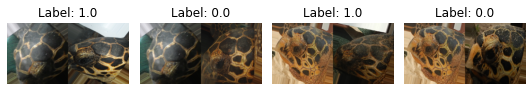

In [130]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

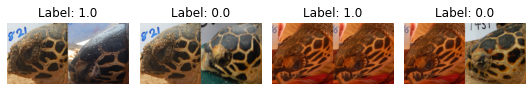

In [131]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

In [144]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


# Block for quick, small CNN
input = layers.Input((224, 224, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)


'''
#Block for Transfer learning CNN
input = layers.Input((224, 224, 3))
x = tf.keras.layers.BatchNormalization()(input)

x = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)(x)

x.trainable = False
'''

x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(124, activation="relu")(x)
embedding_network = keras.Model(input, x)

input_1 = layers.Input((224, 224, 3))
input_2 = layers.Input((224, 224, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 124)          23251284    ['input_12[0][0]',               
                                                                  'input_13[0][0]']         

In [145]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [149]:
# define where to save the model after each epoch
filepath = "../models/contrastive_model.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 4 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=4)
callbacks_list = [checkpoint, early_stopping_monitor]

In [150]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 124)          23251284    ['input_12[0][0]',               
                                                                  'input_13[0][0]']         

In [151]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.4716
Epoch 00001: val_loss improved from inf to 0.30387, saving model to ../models/contrastive_model.h5
32/32 [==============================] - 207s 6s/step - loss: 0.2529 - accuracy: 0.4716 - val_loss: 0.3039 - val_accuracy: 0.2882
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.4971
Epoch 00002: val_loss improved from 0.30387 to 0.27626, saving model to ../models/contrastive_model.h5
32/32 [==============================] - 224s 7s/step - loss: 0.2506 - accuracy: 0.4971 - val_loss: 0.2763 - val_accuracy: 0.2971
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.5284
Epoch 00003: val_loss did not improve from 0.27626
32/32 [==============================] - 227s 7s/step - loss: 0.2501 - accuracy: 0.5284 - val_loss: 0.5562 - val_accuracy: 0.2882
Epoch 4/40
32/32 [==============================] - ETA: 0s - loss: 0.2501 

KeyboardInterrupt: 

## Visualize the results

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [ ]:
#size of the plots
fig=plt.figure(figsize=(15,5))
columns = 2
rows = 1

#plot loss
#the accuracy and loss are stored in the "model_history"
fig.add_subplot(rows, columns, 1)
plt.plot(model_history.history['loss']+ model_history_2.history['loss']) #merge the loss from the two training steps
plt.plot(model_history.history['val_loss']+ model_history_2.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot accuracy
fig.add_subplot(rows, columns, 2)
plt.plot(model_history.history['acc']+ model_history_2.history['acc'])
plt.plot(model_history.history['val_acc']+ model_history_2.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Testing the model + submission

Prepare the data for submission

In [ ]:
#load the best saved trained model
model=load_model("../models/contrastive_model.h5")

In [ ]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory="../sorted_images/test", #This folder should contain pictures of each bird in a different subfolder (similar to the training data set)
        target_size=(224, 224),
        batch_size=490, #number of images in the testing dataset
        shuffle=False)

In [ ]:
#load the pictures in the testing folder. The x_batch contains the pictures and the y_batch contains the
#identities of the individuals
x_test, y_test=next(val_sony_datagen)

In [ ]:
# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [ ]:
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

In [ ]:
results=combined_model.predict([x_test_1, x_test_2])

In [ ]:
predictions_index = []
predictions_probabilities = []
result = []

for i in range(0,len(x_batch)):    
    probabilities_sorted = []
    index_sorted = [] 
    result = results[i]
    y_preds_indices = np.argsort(result)[-5:]
    top_5_values = [result[j] for j in y_preds_indices]
    
    #print(y_preds_indices)
    #print(top_5_values)
    for index in range(1,6):
        probabilities_sorted.append(top_5_values[-index])
        index_sorted.append(y_preds_indices[-index])
        #print(probabilities_sorted)
        #print(index_sorted)
    predictions_probabilities.append(probabilities_sorted)
    predictions_index.append(index_sorted)

In [ ]:
#Create labels to connect indices with turtle_ids (folder structure in train)
labels = list(train_generator.class_indices.keys())

In [ ]:
#Create dataframe for image_ids in order of validation generator (folder structure in val)
images_ids = list(val_sony_datagen.class_indices.keys())
titles = ['image_id']
test_data = pd.DataFrame(images_ids,columns=titles)

In [ ]:
#train_data = pd.read_csv('../data/train_corrected.csv')
#unique_turtle_ids = list(train_data['turtle_id'].unique())

list = []
array = []
for line in predictions_index:
    for id in line:
        list.append(labels[id])
    array.append(list)
    list = []
    
titles = ['prediction1', 'prediction2','prediction3','prediction4','prediction5']
submission = pd.DataFrame(array, columns= titles)

#Insert image_ids from test_data

submission.insert(loc=0, column='image_id', value=test_data['image_id'])
submission

In [ ]:
submission

In [ ]:
#Save submission data as CSV
submission.to_csv('../data/submission_contrastive.csv', index = False)